
***
 *Chen NK* | *Wu PH* 

In [1]:
# julia 1.0.1

###### define the parameters in the next 7 lines
magnitude_nii_file = string("data/magnitude.nii");
phase_nii_file = string("data/phase.nii");
partiallyUnwrapped_nii_file = string("data/partiallyUnwrappedMap.nii");
criticalROI_nii_file = string("data/criticalROI.nii");
ChooseThisSlice = Int64(5); # process data in a chosen slice; e.g., slice #5 in this case
criticalROILabel = Int64(1); # unwrap phase values inside a critical ROI labeled with an integer number; e.g., 1 in this case
output_nii_file = string("data/output.nii");

The main program starts here; no need to modify the code below (although you could use different value of patchsize)

In [2]:
push!(LOAD_PATH,"juliafunction");
using PyPlot
using Read_NIfTI1
using myFun
using Distributed
# addprocs(Sys.CPU_THREADS-nprocs());
# nprocs()
@everywhere using FFTW
@everywhere using LinearAlgebra
@everywhere using SharedArrays

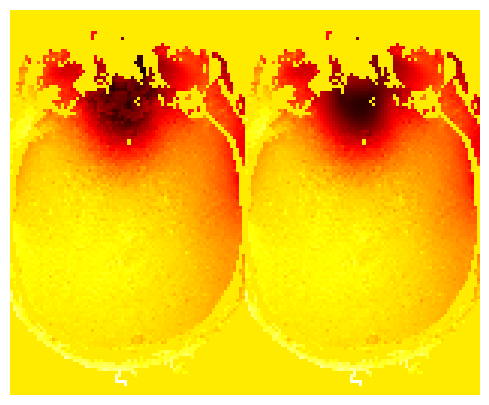

11.629099 seconds (2.42 M allocations: 3.519 GiB, 9.63% gc time)


In [3]:
function julia_main(magnitude_nii_file::String,phase_nii_file::String,partiallyUnwrapped_nii_file::String,criticalROI_nii_file::String,ChooseThisSlice::Int64,criticalROILabel::Int64)
    headerinfo1 = load_nii_header(magnitude_nii_file);
    data001 = load_nii_data(magnitude_nii_file, headerinfo1);
    headerinfo1 = load_nii_header(phase_nii_file);
    data002 = load_nii_data(phase_nii_file, headerinfo1);
    imagedata_noise = data001 .* exp.(complex(0,1)*data002);

    imgsn = imagedata_noise[:,:,ChooseThisSlice];
    ksn = ifftshift(ifft(ifftshift(imgsn)));

    @everywhere function sidm(kdata::Array{Complex{Float32},2})
        kabs = abs.(kdata);
        pxpy = findall(kabs .== maximum(kabs));
        px = pxpy[1][1];
        py = pxpy[1][2];
        return (px,py);
    end

    datasize1,datasize2 = size(imgsn)

    pxmap = SharedArray{Float64,2}((datasize1,datasize2));
    pymap = SharedArray{Float64,2}((datasize1,datasize2));

    patchsize = 7;
    patchsize = patchsize + div(1 + (-1).^patchsize,2)
    ps1 = max(div((patchsize-1),2),1);

    @time @sync @distributed for cntx = 1:datasize1
        @inbounds @fastmath @simd for cnty = 1:datasize2
            tmp1 = zeros(ComplexF32,(datasize1,datasize2));
            startingx = max(1,cntx-ps1);
            startingy = max(1,cnty-ps1);
            endingx = min(cntx+ps1,datasize1);
            endingy = min(cnty+ps1,datasize2);
            tmp1[startingx:endingx,startingy:endingy] = imgsn[startingx:endingx,startingy:endingy];
            tmp2 = ifftshift(ifft(ifftshift(tmp1)));
            px,py = sidm(tmp2);
            pxmap[cntx,cnty]=px;
            pymap[cntx,cnty]=py;
        end
    end

    pxmap2a = pxmap.-(datasize1/2);
    pymap2a = pymap.-(datasize2/2);
    pxmap_radppixel = -pxmap2a*2*π/datasize1;
    pymap_radppixel = -pymap2a*2*π/datasize2;

    headerinfo4 = load_nii_header(partiallyUnwrapped_nii_file);
    preludephasemap_all = load_nii_data(partiallyUnwrapped_nii_file, headerinfo4);
    preludephasemap = preludephasemap_all[:,:,ChooseThisSlice];

    preludemask = ones(datasize1,datasize2);
    L = findall(preludephasemap.==0);
    preludemask[L].=0;
    preludephasemap_cpe = closest_point_estimation(preludephasemap,preludemask);

    headerinfo5 = load_nii_header(criticalROI_nii_file);
    criticalROI_all = load_nii_data(criticalROI_nii_file, headerinfo5);
    criticalROI = criticalROI_all[:,:,ChooseThisSlice];

    L2 = findall(criticalROI.==criticalROILabel);

    if length(L2)>0
        xcoordarray = zeros(Int64,length(L2));
        ycoordarray = zeros(Int64,length(L2));
        for cnt = 1:length(L2)
            xcoordarray[cnt] = L2[cnt][1];
            ycoordarray[cnt] = L2[cnt][2];
        end

        roiStartX = minimum(xcoordarray)-1;
        roiEndX = maximum(xcoordarray)+1;
        roiStartY = minimum(ycoordarray)-1;
        roiEndY = maximum(ycoordarray)+1;
        xdim = roiEndX-roiStartX+1;
        ydim = roiEndY-roiStartY+1;

        boundaryConditionMap = convert(Array{Float64},preludephasemap_cpe[roiStartX:roiEndX,roiStartY:roiEndY]);
        mask = ones(xdim,ydim)-criticalROI[roiStartX:roiEndX,roiStartY:roiEndY];
        snr_ref = abs.(imgsn)[roiStartX:roiEndX,roiStartY:roiEndY].*mask;
        λmap = snr_ref ./maximum(snr_ref[:]);
        λmap[:,1].=2.;
        λmap[:,end].=2.;
        λmap[1,:].=2.;
        λmap[end,:].=2.;
        Mgv = pxmap_radppixel[roiStartX:roiEndX,roiStartY:roiEndY];
        Mgh = pymap_radppixel[roiStartX:roiEndX,roiStartY:roiEndY];

        M_recovered = twoDimIntegration(mask,boundaryConditionMap,λmap,Mgv,Mgh);

        newPhaseMap = deepcopy(preludephasemap_cpe);
        newPhaseMap[roiStartX:roiEndX,roiStartY:roiEndY]= M_recovered;
        newPhaseMapMask = newPhaseMap.*preludemask;
    else
        newPhaseMap = preludephasemap;
        newPhaseMapMask = newPhaseMap.*preludemask;
    end

    headerinfo4["datatype"] = Int16(16);
    output_all = convert(Array{Float32,3}, preludephasemap_all);
    newPhaseMapMask = convert(Array{Float32,2}, newPhaseMapMask);
    output_all[:,:,ChooseThisSlice] = newPhaseMapMask;
    write_nii_header(output_nii_file, headerinfo4);
    fid = open(output_nii_file,"a");
    write(fid, output_all);
    close(fid);

    figure(1,figsize=(10,5));imshow(reverse(permutedims(vcat(preludephasemap,newPhaseMapMask),[2,1]),dims=1),cmap="hot",interpolation="none"); axis("off");
#     figure(2,figsize=(10,5));imshow(reverse(permutedims(vcat(preludephasemap_cpe,newPhaseMap),[2,1]),dims=1),cmap="hot",interpolation="none"); axis("off");

end

julia_main(magnitude_nii_file,phase_nii_file,partiallyUnwrapped_nii_file,criticalROI_nii_file,ChooseThisSlice,criticalROILabel);

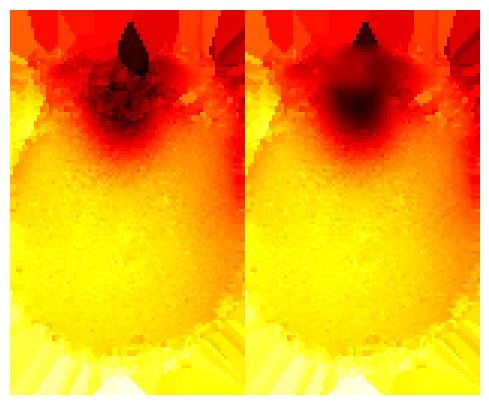

 10.399793 seconds (1.19 M allocations: 3.459 GiB, 5.49% gc time)


In [4]:
function julia_main(magnitude_nii_file::String,phase_nii_file::String,partiallyUnwrapped_nii_file::String,criticalROI_nii_file::String,ChooseThisSlice::Int64,criticalROILabel::Int64)
    headerinfo1 = load_nii_header(magnitude_nii_file);
    data001 = load_nii_data(magnitude_nii_file, headerinfo1);
    headerinfo1 = load_nii_header(phase_nii_file);
    data002 = load_nii_data(phase_nii_file, headerinfo1);
    imagedata_noise = data001 .* exp.(complex(0,1)*data002);

    imgsn = imagedata_noise[:,:,ChooseThisSlice];
    ksn = ifftshift(ifft(ifftshift(imgsn)));

    @everywhere function sidm(kdata::Array{Complex{Float32},2})
        kabs = abs.(kdata);
        pxpy = findall(kabs .== maximum(kabs));
        px = pxpy[1][1];
        py = pxpy[1][2];
        return (px,py);
    end

    datasize1,datasize2 = size(imgsn)

    pxmap = SharedArray{Float64,2}((datasize1,datasize2));
    pymap = SharedArray{Float64,2}((datasize1,datasize2));

    patchsize = 7;
    patchsize = patchsize + div(1 + (-1).^patchsize,2)
    ps1 = max(div((patchsize-1),2),1);

    @time @sync @distributed for cntx = 1:datasize1
        @inbounds @fastmath @simd for cnty = 1:datasize2
            tmp1 = zeros(ComplexF32,(datasize1,datasize2));
            startingx = max(1,cntx-ps1);
            startingy = max(1,cnty-ps1);
            endingx = min(cntx+ps1,datasize1);
            endingy = min(cnty+ps1,datasize2);
            tmp1[startingx:endingx,startingy:endingy] = imgsn[startingx:endingx,startingy:endingy];
            tmp2 = ifftshift(ifft(ifftshift(tmp1)));
            px,py = sidm(tmp2);
            pxmap[cntx,cnty]=px;
            pymap[cntx,cnty]=py;
        end
    end

    pxmap2a = pxmap.-(datasize1/2);
    pymap2a = pymap.-(datasize2/2);
    pxmap_radppixel = -pxmap2a*2*π/datasize1;
    pymap_radppixel = -pymap2a*2*π/datasize2;

    headerinfo4 = load_nii_header(partiallyUnwrapped_nii_file);
    preludephasemap_all = load_nii_data(partiallyUnwrapped_nii_file, headerinfo4);
    preludephasemap = preludephasemap_all[:,:,ChooseThisSlice];

    preludemask = ones(datasize1,datasize2);
    L = findall(preludephasemap.==0);
    preludemask[L].=0;
    preludephasemap_cpe = closest_point_estimation(preludephasemap,preludemask);

    headerinfo5 = load_nii_header(criticalROI_nii_file);
    criticalROI_all = load_nii_data(criticalROI_nii_file, headerinfo5);
    criticalROI = criticalROI_all[:,:,ChooseThisSlice];

    L2 = findall(criticalROI.==criticalROILabel);

    if length(L2)>0
        xcoordarray = zeros(Int64,length(L2));
        ycoordarray = zeros(Int64,length(L2));
        for cnt = 1:length(L2)
            xcoordarray[cnt] = L2[cnt][1];
            ycoordarray[cnt] = L2[cnt][2];
        end

        roiStartX = minimum(xcoordarray)-1;
        roiEndX = maximum(xcoordarray)+1;
        roiStartY = minimum(ycoordarray)-1;
        roiEndY = maximum(ycoordarray)+1;
        xdim = roiEndX-roiStartX+1;
        ydim = roiEndY-roiStartY+1;

        boundaryConditionMap = convert(Array{Float64},preludephasemap_cpe[roiStartX:roiEndX,roiStartY:roiEndY]);
        mask = ones(xdim,ydim)-criticalROI[roiStartX:roiEndX,roiStartY:roiEndY];
        snr_ref = abs.(imgsn)[roiStartX:roiEndX,roiStartY:roiEndY].*mask;
        λmap = snr_ref ./maximum(snr_ref[:]);
        λmap[:,1].=2.;
        λmap[:,end].=2.;
        λmap[1,:].=2.;
        λmap[end,:].=2.;
        Mgv = pxmap_radppixel[roiStartX:roiEndX,roiStartY:roiEndY];
        Mgh = pymap_radppixel[roiStartX:roiEndX,roiStartY:roiEndY];

        M_recovered = twoDimIntegration(mask,boundaryConditionMap,λmap,Mgv,Mgh);

        newPhaseMap = deepcopy(preludephasemap_cpe);
        newPhaseMap[roiStartX:roiEndX,roiStartY:roiEndY]= M_recovered;
        newPhaseMapMask = newPhaseMap.*preludemask;
    else
        newPhaseMap = preludephasemap;
        newPhaseMapMask = newPhaseMap.*preludemask;
    end

    headerinfo4["datatype"] = Int16(16);
    output_all = convert(Array{Float32,3}, preludephasemap_all);
    newPhaseMapMask = convert(Array{Float32,2}, newPhaseMapMask);
    output_all[:,:,ChooseThisSlice] = newPhaseMapMask;
    write_nii_header(output_nii_file, headerinfo4);
    fid = open(output_nii_file,"a");
    write(fid, output_all);
    close(fid);

    #figure(1,figsize=(10,5));imshow(reverse(permutedims(vcat(preludephasemap,newPhaseMapMask),[2,1]),dims=1),cmap="hot",interpolation="none"); axis("off");
    figure(2,figsize=(10,5));imshow(reverse(permutedims(vcat(preludephasemap_cpe,newPhaseMap),[2,1]),dims=1),cmap="hot",interpolation="none"); axis("off");

end

julia_main(magnitude_nii_file,phase_nii_file,partiallyUnwrapped_nii_file,criticalROI_nii_file,ChooseThisSlice,criticalROILabel);